In [2]:
import matplotlib.pyplot as plt
import glob
import torch
import numpy as np
import networkx as nx
import os
import matplotlib as mpl
plt.rcParams.update({'font.size': 16})

In [3]:
# Load the data
data_dir = "../results_scaling/"

# Delaunay
#sub_dir = os.path.join(data_dir, "2021-11-22_06-01_scaling_dinno_const_fied") 

# Star
#sub_dir = os.path.join(data_dir, "2021-11-20_07-04_scaling_dinno_const_fied") 

# Disk
sub_dir = os.path.join(data_dir, "2021-11-22_15-52_scaling_dinno_const_fied") 

graph_pickles = glob.glob1(sub_dir, "*.gpickle")
num_trials = len(graph_pickles)

results_all = []
graphs_all = []
for k in range(num_trials):
    graph_path = os.path.join(sub_dir, str(k) + ".gpickle")
    results_path = os.path.join(sub_dir, str(k) + "_results.pt")
    graph = nx.read_gpickle(graph_path)
    results = torch.load(results_path, map_location=torch.device("cpu"))
    graphs_all.append(graph)
    results_all.append(results)

Text(0, 0.5, 'Iterations to Reach')

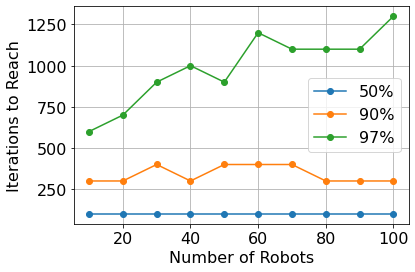

In [4]:
fig, ax = plt.subplots(tight_layout=False)
Ns = [len(graphs_all[k].nodes) for k in range(num_trials)]
it0 = []
it1 = []
it2 = []
for k in range(num_trials):
    acc = results_all[k]["top1_accuracy"]
    acc = torch.stack(acc)
    mean = torch.mean(acc, dim=1)
    t = torch.arange(acc.shape[0]) * 100
    
    it0.append(t[np.argmax(mean>0.5)])
    it1.append(t[np.argmax(mean>0.9)])
    it2.append(t[np.argmax(mean>0.97)])

ax.plot(Ns, it0, label="50%", marker="o")
ax.plot(Ns, it1, label="90%", marker="o")
ax.plot(Ns, it2, label="97%", marker="o")
ax.legend()
ax.grid()
ax.set_xlabel("Number of Robots")
ax.set_ylabel("Iterations to Reach")


Text(0.5, 0, 'Number of Robots')

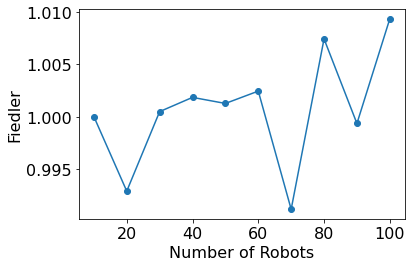

In [5]:
fieds = [nx.linalg.algebraic_connectivity(graphs_all[k]) for k in range(num_trials)]
Ns = [len(graphs_all[k].nodes) for k in range(num_trials)]

fig, ax = plt.subplots(tight_layout=True)
ax.plot(Ns, fieds, marker="o")
ax.set_ylabel("Fiedler")
ax.set_xlabel("Number of Robots")

In [6]:
# Load the data
data_dir = "../results_scaling/"

# Decreasing Fiedler
sub_dir = os.path.join(data_dir, "2021-11-23_15-43_scaling_dinno_const_fied") 

graph_pickles = glob.glob1(sub_dir, "*.gpickle")
num_trials = len(graph_pickles)

results_all = []
graphs_all = []
for k in range(num_trials):
    graph_path = os.path.join(sub_dir, str(k) + ".gpickle")
    results_path = os.path.join(sub_dir, str(k) + "_results.pt")
    graph = nx.read_gpickle(graph_path)
    results = torch.load(results_path, map_location=torch.device("cpu"))
    graphs_all.append(graph)
    results_all.append(results)

Text(0, 0.5, 'Iterations to Reach')

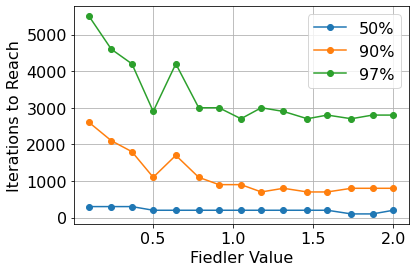

In [7]:
fig, ax = plt.subplots(tight_layout=False)
Ns = [len(graphs_all[k].nodes) for k in range(num_trials)]
fieds = [nx.linalg.algebraic_connectivity(graphs_all[k]) for k in range(num_trials)]
it0 = []
it1 = []
it2 = []
for k in range(num_trials):
    acc = results_all[k]["top1_accuracy"]
    acc = torch.stack(acc)
    mean = torch.mean(acc, dim=1)
    t = torch.arange(acc.shape[0]) * 100
    
    it0.append(t[np.argmax(mean>0.5)])
    it1.append(t[np.argmax(mean>0.9)])
    it2.append(t[np.argmax(mean>0.97)])

ax.plot(fieds, it0, label="50%", marker="o")
ax.plot(fieds, it1, label="90%", marker="o")
ax.plot(fieds, it2, label="97%", marker="o")
ax.legend()
ax.grid()
ax.set_xlabel("Fiedler Value")
ax.set_ylabel("Iterations to Reach")

In [8]:
import random

def fied_from_disk(N, positions, radius):
    G = nx.random_geometric_graph(N, radius, pos=positions)
    return nx.linalg.algebraic_connectivity(G, tol=1e-3, method='lanczos')
    
def disk_with_fied(N, targ, num_restarts=50):
    for _ in range(num_restarts):
        pos = {i: (random.random(), random.random()) for i in range(N)}
        
        # +/- tolerance to target
        tol = 0.01

        #initial bounds 
        lbr = 0.05
        ubr = 0.8
        
        lbf = fied_from_disk(N, pos, lbr)
        ubf = fied_from_disk(N, pos, ubr)
        
        if abs(lbf - targ) < tol:
            return nx.random_geometric_graph(N, lbr, pos=pos)

        if abs(ubf - targ) < tol:
            return nx.random_geometric_graph(N, ubr, pos=pos)
        
        if not ubf > lbf:
            print("upper bound fied", ubf)
            print("lower bound fied", lbf)
            raise NameError("Not sure whats happening in graph gen")
        
        if targ > ubf or targ < lbf:
            print("upper bound fied", ubf)
            print("lower bound fied", lbf)
            raise NameError("Target outside range.")

        flag = True
        c = 0
        while flag:
            midr = (ubr + lbr) / 2
            
            midf = fied_from_disk(N, pos, midr)
            
            if abs(midf - targ) < tol:
                return nx.random_geometric_graph(N, midr, pos=pos)
            
            if midf > targ:
                ubr = midr
                ubf = midf
            elif midf < targ:
                lbr = midr
                lbf = midf
            
            if c > 100:
                break
            else:
                c += 1
    
    raise("Never found a viable graph!")
        

In [9]:
Ns = torch.linspace(10, 100, 10).int().tolist()


for N in Ns:
    print(N)
    G = disk_with_fied(N, 1.0)
    if G is None:
        break
        

10
20
30
40
50
60
70
80
90
100


In [10]:
fieds = torch.linspace(0.1, 2.0, 15).tolist()

for fied in fieds:
    G = disk_with_fied(20, fied)
    print("Success on: ", fied)

Success on:  0.10000000149011612
Success on:  0.23571428656578064
Success on:  0.37142854928970337
Success on:  0.5071428418159485
Success on:  0.6428571343421936
Success on:  0.778571367263794
Success on:  0.9142856597900391
Success on:  1.0500000715255737
Success on:  1.1857143640518188
Success on:  1.321428656578064
Success on:  1.4571428298950195
Success on:  1.5928571224212646
Success on:  1.7285714149475098
Success on:  1.8642857074737549
Success on:  2.0
